1. Import necessary packages, and read in data
2. Preprocessing data and apriori feature selection
3. Random Forest: model training, tuning, and evaluation
4. Testing it out!

# Import necessary packages, and read in data

In [121]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [122]:
path = 'C:\Data_Science_Engineering_Methonds_And_Tools\Info_6105\Module_7'

In [123]:
df = pd.read_csv(f'{path}/Titanic_full.csv')
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# 2. Preprocessing data and apriori feature selection

In the broadest sense of the term, preprocessing can also include feature selection. Here, we will use our
rationale to feature select. What do the column names mean, does it make sense to what we are trying to do, and should we keep it or drop it?

There are different ways to think about it. For now, let's drop Name, Cabin and Ticket columns.

Let's see if this makes a difference.

In [124]:
'''Keep aside test data first'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_trn_val,df_tst = mydf_splitter(df,1150)

print(df_trn_val.shape,df_tst.shape)

(1150, 12) (159, 12)


In [125]:
 df_trn_val1 = df_trn_val.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_trn_val1.shape)
df_trn_val1.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


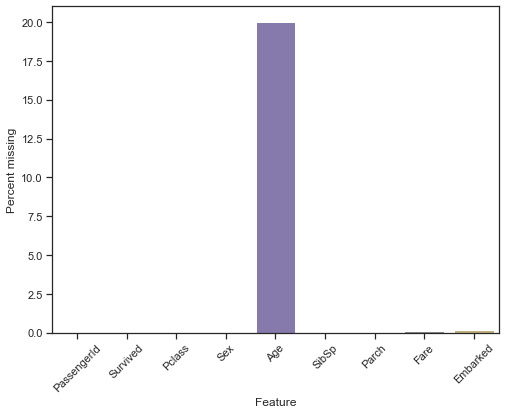

In [126]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_trn_val1.isnull().sum()/len(df_trn_val1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [127]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [128]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [129]:
df_trn_val2 = str_to_cat(df_trn_val1)
print(df_trn_val2.shape)
df_trn_val2.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


In [130]:
df_trn_val3,my_table = mydf_preprocessor(df_trn_val2,null_table = None)
print(df_trn_val3.shape)
df_trn_val3.head(3)

(1150, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,1,0,3,2,22.0,1,0,7.2500,3,False,False
1,2,1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,3,1,26.0,0,0,7.9250,3,False,False


In [131]:
my_table

{'Age': 28.0, 'Fare': 14.4542}

In [132]:
x = df_trn_val3.drop('Survived', axis=1)
y = df_trn_val3['Survived']

In [133]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(862, 10) (288, 10) (862,) (288,)


# Random Forest: model training, tuning, and evaluation

In [134]:
#By training the models with different values of n_estimators we can see a change in the accuracy score

In [135]:
mod_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
mod_1.fit(x_trn,y_trn)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [136]:
y_prd = mod_1.predict(x_val)
accuracy_score(y_val,y_prd)


0.7361111111111112

In [137]:
mod_2 = RandomForestClassifier(n_jobs = -1, n_estimators = 50,
                                 bootstrap = True)
mod_2.fit(x_trn,y_trn)
y_prd2 = mod_2.predict(x_val)
accuracy_score(y_val,y_prd2)


0.7569444444444444

In [138]:
mod_3 = RandomForestClassifier(n_jobs = -1, n_estimators = 300,max_features = 0.25,
                               bootstrap = True)
mod_3.fit(x_trn,y_trn)
y_prd3 = mod_3.predict(x_val)
accuracy_score(y_val,y_prd3)


0.7326388888888888

In [139]:
mod_4 = RandomForestClassifier(n_jobs = -1, n_estimators = 500,max_features = 0.25,
                               bootstrap = True)
mod_4.fit(x_trn,y_trn)
y_prd4 = mod_4.predict(x_val)
accuracy_score(y_val,y_prd4)


0.75

In [140]:
mod_5 = RandomForestClassifier(n_jobs = -1, n_estimators = 600,max_features = 0.25,
                               bootstrap = True)
mod_5.fit(x_trn,y_trn)
y_prd5 = mod_5.predict(x_val)
accuracy_score(y_val,y_prd5)


0.7430555555555556

In [141]:
mod_6 = RandomForestClassifier(n_jobs = -1, n_estimators = 800,max_features = 0.25,
                               bootstrap = True)
mod_6.fit(x_trn,y_trn)
y_prd6 = mod_6.predict(x_val)
accuracy_score(y_val,y_prd6)


0.7465277777777778

In [144]:
df_eval = pd.DataFrame({'n_estimators':[10, 50, 300, 500, 600, 800], 'accuracy_score':[0.725, 0.729,0.732, 0.7465, 0.75, 0.753]})
df_eval

,n_estimators,accuracy_score
0,10,0.7250
1,50,0.7290
2,300,0.7320
3,500,0.7465
4,600,0.7500
5,800,0.7530


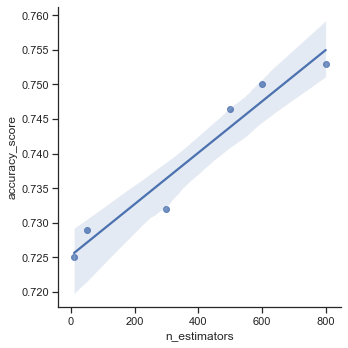

In [145]:
sns.set(style="ticks")
sns.lmplot(x='n_estimators', y = 'accuracy_score', data = df_eval)

In [146]:
#As seen in the above plot, the accuracy_score increases with an increase in n_estimators

# 4.  Testing it out!

In [147]:
'''Preprocess test set exactly like the train and validation sets'''

df_tst1 = df_tst.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_tst1.shape)
df_tst1.head(3)

(159, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1150,1151,1,3,male,21.0,0,0,7.7750,S
1151,1152,0,3,male,36.5,1,0,17.4000,S
1152,1153,1,3,male,21.0,0,0,7.8542,S


In [148]:
df_tst2 = str_to_cat(df_tst1)
df_tst2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [149]:
df_tst2,my_table1 = mydf_preprocessor(df_tst1,
                                         null_table = my_table)
print(df_tst2.shape)
df_tst2.head(3)

(159, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
1150,1151,1,3,2,21.0,0,0,7.7750,3,False,False
1151,1152,0,3,2,36.5,1,0,17.4000,3,False,False
1152,1153,1,3,2,21.0,0,0,7.8542,3,False,False


In [150]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!


y_tst = df_tst2["Survived"]
x_tst = df_tst2.drop(["Survived"],axis = 1)

print(x_tst.shape,y_tst.shape)

(159, 10) (159,)


In [151]:
y_prd_tst = mod_1.predict(x_tst)
accuracy_score(y_tst,y_prd_tst)

0.5408805031446541

In [152]:
y_prd_tst2 = mod_2.predict(x_tst)
accuracy_score(y_tst,y_prd_tst2)

0.5283018867924528

In [153]:
y_prd_tst3 = mod_3.predict(x_tst)
accuracy_score(y_tst,y_prd_tst3)

0.5534591194968553

In [154]:
y_prd_tst4 = mod_4.predict(x_tst)
accuracy_score(y_tst,y_prd_tst4)

0.5534591194968553

In [155]:
y_prd_tst5 = mod_5.predict(x_tst)
accuracy_score(y_tst,y_prd_tst5)

0.5283018867924528

In [156]:
y_prd_tst6 = mod_6.predict(x_tst)
accuracy_score(y_tst,y_prd_tst6)

0.5471698113207547

In [157]:
df_eval_test = pd.DataFrame({'n_estimators':[10, 50, 300, 500, 600, 800], 'accuracy_score':[0.540, 0.534,0.553, 0.522, 0.553, 0.540]})
df_eval_test

,n_estimators,accuracy_score
0,10,0.540
1,50,0.534
2,300,0.553
3,500,0.522
4,600,0.553
5,800,0.540


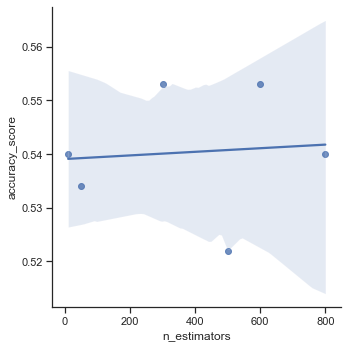

In [158]:
sns.set(style="ticks")
sns.lmplot(x='n_estimators', y = 'accuracy_score', data = df_eval_test)

In [120]:
#Plot of n_estimators vs accuracy_score as observed on the test set